In [1]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from deepcell_toolbox.processing import histogram_normalization,normalize
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell.applications import CytoplasmSegmentation,NuclearSegmentation
from deepcell_spots.applications import Polaris
from deepcell_spots.singleplex import *

class OverrideCytoplamSegmentation(CytoplasmSegmentation):

    def __init__(self, model=None):
        super(CytoplasmSegmentation, self).__init__(model, model_image_shape=(512, 512, 1))
        # Override preprocessing input
        self.preprocessing_fn = histogram_normalization        
        self.postprocessing_fn = deep_watershed

## Import images

In [2]:
from tensorflow.keras.utils import get_file
from deepcell.datasets import Dataset

def load_data(self, path=None, test_size=0.2, seed=0):
    path = path if path else self.path
    
    basepath = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
    prefix = path.split(os.path.sep)[:-1]
    data_dir = os.path.join(basepath, *prefix) if prefix else basepath
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    elif not os.path.isdir(data_dir):
        raise IOError('{} exists but is not a directory'.format(data_dir))

    path = get_file(path,
                    origin=self.url,
                    file_hash=self.file_hash)
    
    data = Image.open(path)
    
    return(data)

Dataset.load_data = load_data

In [3]:
from deepcell.datasets import Dataset

datafile = Dataset(
    path='scGFP_Maximum intensity projection.tif',
    url='https://deepcell-data.s3.us-west-1.amazonaws.com/spot_detection/singleplex/scGFP_Maximum+intensity+projection.tif',
    file_hash='a0e5c38ef3b26e521d3837f1098393c4',
    metadata={})
image_stack = datafile.load_data()

In [4]:
image_stack.seek(0)
fluor_image = np.expand_dims(np.array(image_stack), axis=[0,-1])
image_stack.seek(1)
cyto_image = np.expand_dims(np.array(image_stack), axis=[0,-1])
image_stack.seek(2)
nuc_image = np.expand_dims(np.array(image_stack), axis=[0,-1])
image_stack.seek(3)
spots_image = np.expand_dims(np.array(image_stack), axis=[0,-1])

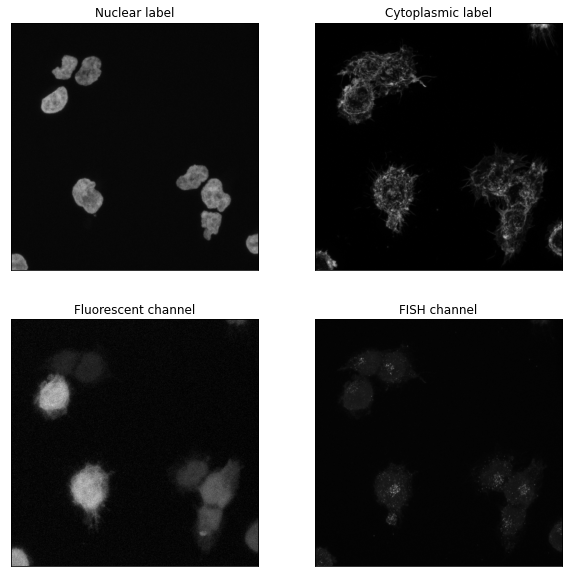

In [5]:
fig,ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].imshow(nuc_image[0,...,0],cmap='gray')
ax[0,0].set_title('Nuclear label')
ax[0,1].imshow(cyto_image[0,...,0],cmap='gray')
ax[0,1].set_title('Cytoplasmic label')
ax[1,0].imshow(fluor_image[0,...,0],cmap='gray')
ax[1,0].set_title('Fluorescent channel')
ax[1,1].imshow(spots_image[0,...,0],cmap='gray')
ax[1,1].set_title('FISH channel')

for i in range(np.shape(ax)[0]):
    for ii in range(np.shape(ax)[1]):
        ax[i,ii].set_xticks([])
        ax[i,ii].set_yticks([])

plt.show()

## Nuclear segmentation

In [6]:
# Initialize nuclear segmentation application
nuc_app = NuclearSegmentation()

In [7]:
# Predict nuclear segmentation
# image_mpp is estimate for pixel size in microns

labeled_im_nuc = nuc_app.predict(nuc_image,image_mpp=0.15)

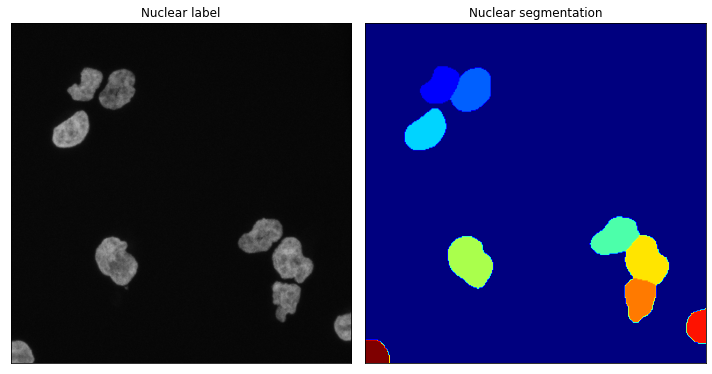

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(nuc_image[0, ..., 0],cmap='gray')
ax[0].set_title('Nuclear label')
ax[1].imshow(labeled_im_nuc[0, ..., 0], cmap='jet')
ax[1].set_title('Nuclear segmentation')

for i in range(len(ax)):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

## Cytoplasmic segmentation

In [9]:
import tensorflow as tf

model = tf.keras.models.load_model('./models/CytoplasmSegmentation')

In [10]:
# Initialize cytoplasm segmentation application
cyto_app = OverrideCytoplamSegmentation(model=model)

In [11]:
# Predict cytoplasmic segmentation
# image_mpp is estimate for pixel size in microns

labeled_im_cyto = cyto_app.predict(fluor_image, image_mpp=0.15)

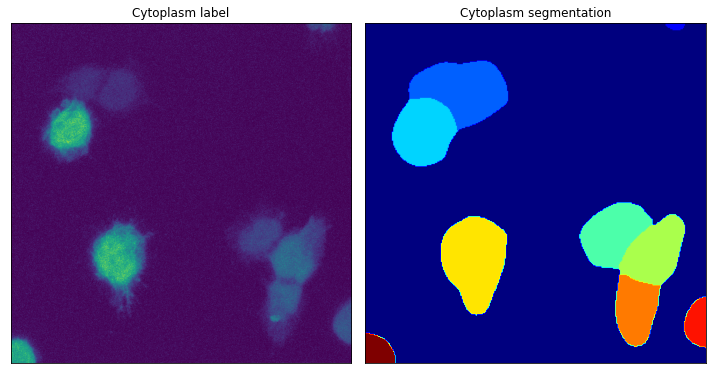

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(fluor_image[0, ..., 0])
ax[0].set_title('Cytoplasm label')
ax[1].imshow(labeled_im_cyto[0, ..., 0], cmap='jet')
ax[1].set_title('Cytoplasm segmentation')
for i in range(len(ax)):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

## Spot detection

In [13]:
# Initialize spot detection application
spots_app = Polaris()

In [14]:
# Predict spot locations
# threshold is the threshold probability used to determine spot locations
# threshold=0.95 means that spots returned are predicted to have a 99% chance of being a spot

coords = spots_app.predict(spots_image,threshold=0.99)

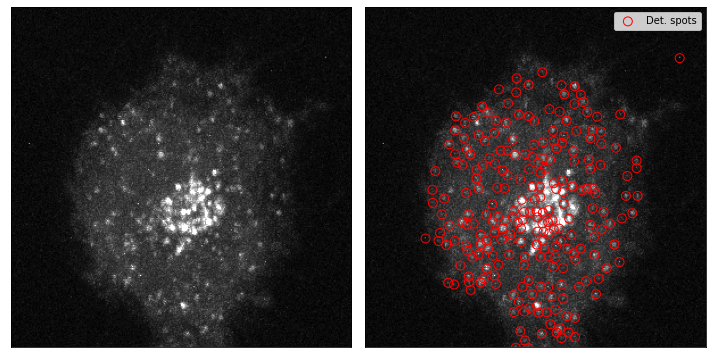

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(spots_image[0, ..., 0],cmap='gray',vmax=75)
ax[1].imshow(spots_image[0, ..., 0],cmap='gray',vmax=75)
ax[1].scatter(coords[0][:,1],coords[0][:,0],facecolors='None',edgecolors='r',label='Det. spots',s=80)
plt.legend()
for i in range(len(ax)):
    ax[i].set_xlim([250,550])
    ax[i].set_ylim([1000,700])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.tight_layout()
plt.show()

## Match spots to cells

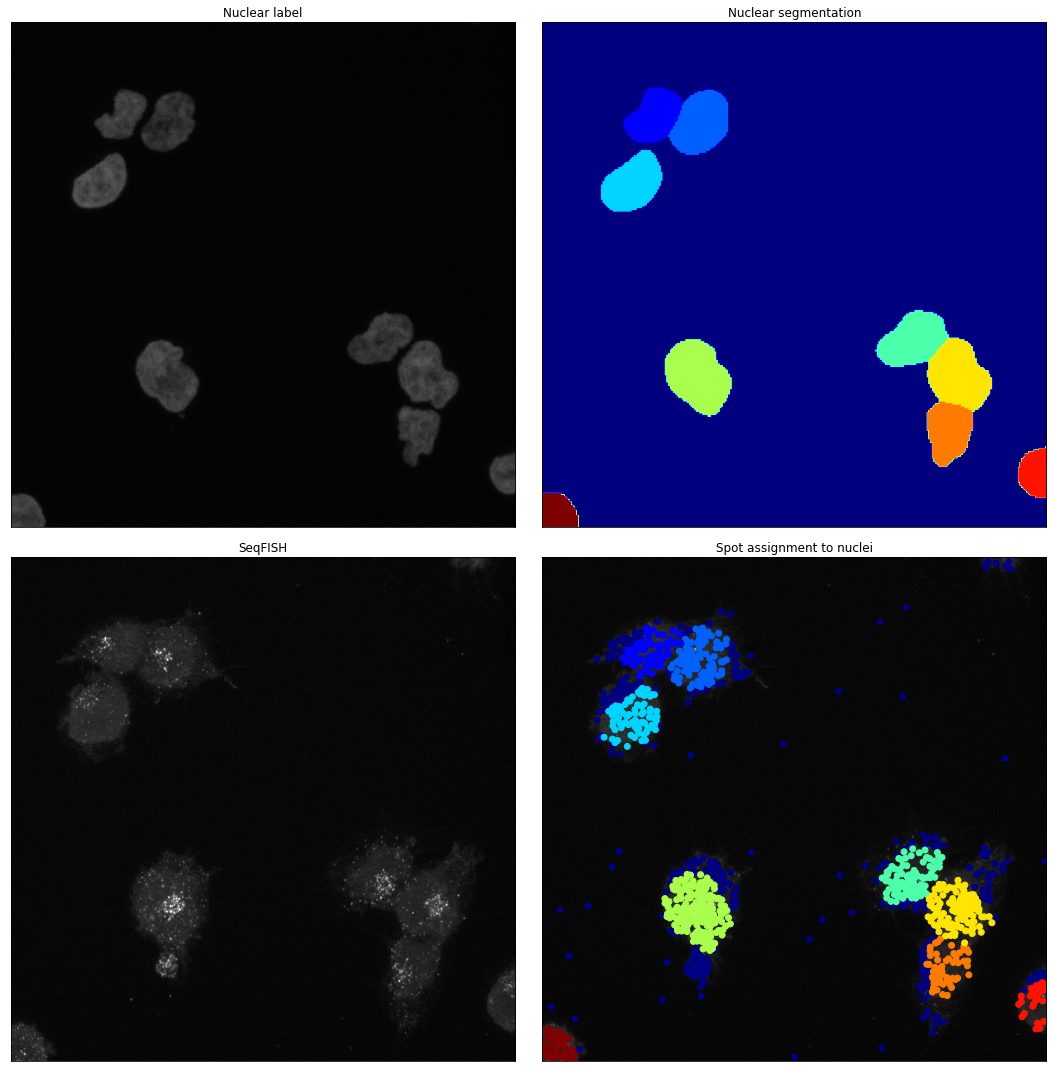

In [16]:
## Assign spots to nuclei

spot_dict_nuc = match_spots_to_cells(labeled_im_nuc,coords[0])
coords_new,cmap_list = process_spot_dict(spot_dict_nuc)

fig,ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].imshow(nuc_image[0,...,0],cmap='gray',vmax=100)
ax[0,0].set_title('Nuclear label')
ax[0,1].imshow(labeled_im_nuc[0,...,0],cmap='jet')
ax[0,1].set_title('Nuclear segmentation')
ax[1,0].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[1,0].set_title('SeqFISH')
ax[1,1].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[1,1].scatter(coords_new[:,1],coords_new[:,0],c=cmap_list,cmap='jet')
ax[1,1].set_title('Spot assignment to nuclei')

for i in range(np.shape(ax)[0]):
    for ii in range(np.shape(ax)[1]):
        ax[i,ii].set_xticks([])
        ax[i,ii].set_yticks([])

plt.tight_layout()
plt.show()

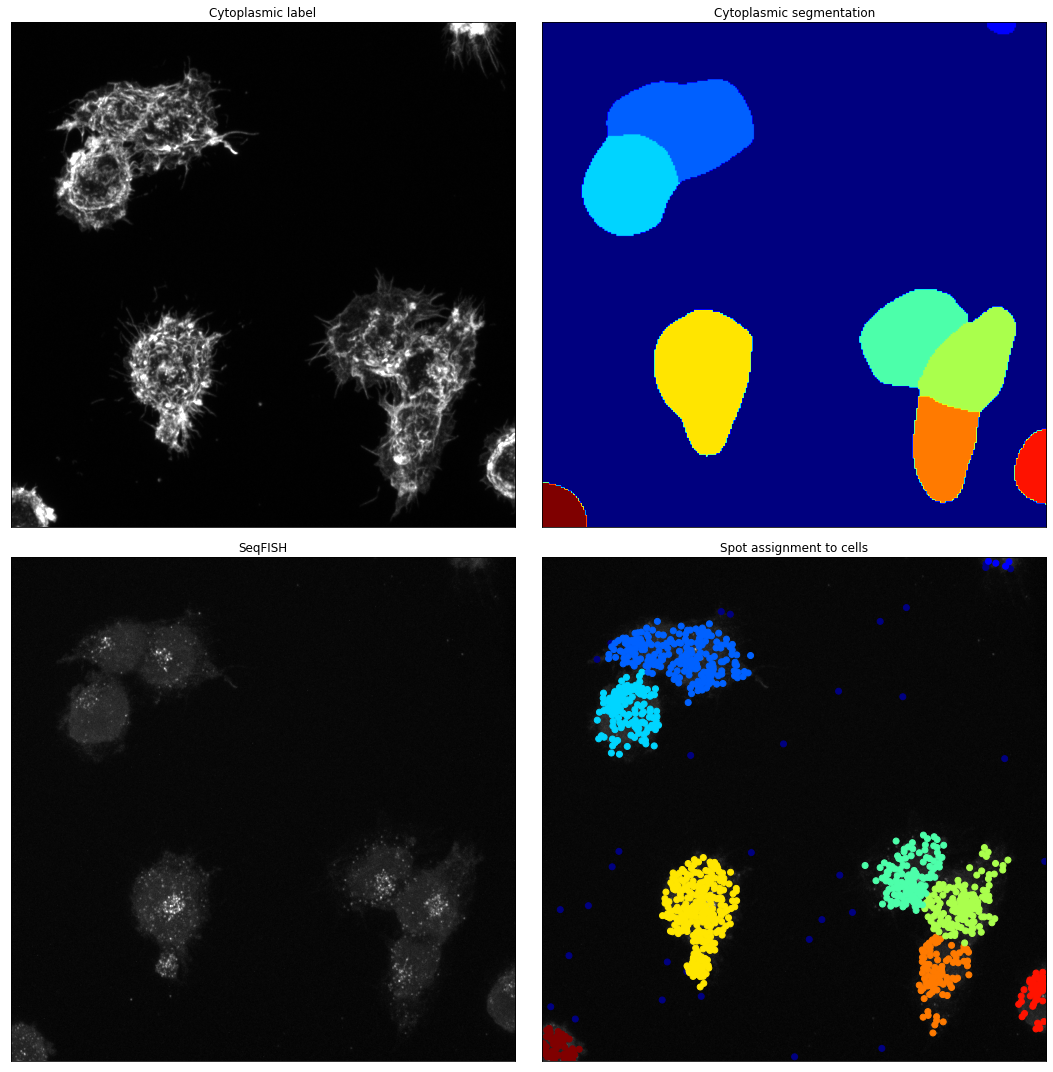

In [17]:
## Assign spots to cytoplasm

spot_dict_cyto = match_spots_to_cells(labeled_im_cyto,coords[0])
coords_new,cmap_list = process_spot_dict(spot_dict_cyto)

fig,ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].imshow(cyto_image[0,...,0],cmap='gray',vmax=100)
ax[0,0].set_title('Cytoplasmic label')
ax[0,1].imshow(labeled_im_cyto[0,...,0],cmap='jet')
ax[0,1].set_title('Cytoplasmic segmentation')
ax[1,0].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[1,0].set_title('SeqFISH')
ax[1,1].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[1,1].scatter(coords_new[:,1],coords_new[:,0],c=cmap_list,cmap='jet')
ax[1,1].set_title('Spot assignment to cells')

for i in range(np.shape(ax)[0]):
    for ii in range(np.shape(ax)[1]):
        ax[i,ii].set_xticks([])
        ax[i,ii].set_yticks([])

plt.tight_layout()
plt.show()